## Семинар 6. 
k-means
Алгоритм k-means ищет заранее определенное количество кластеров в немаркированном многомерном наборе данных. Это достигается с помощью простой концепции того, как выглядит оптимальная кластеризация:

1. «Центр кластеров» - это среднее арифметическое координат всех точек, принадлежащих кластеру.
2. Каждая точка ближе к собственному центру кластера, чем к другим кластерным центрам.
3. Эти два предположения лежат в основе модели k-means. 

Сначала давайте создадим двумерный набор данных, содержащий четыре различных капли. Чтобы подчеркнуть, что это неконтролируемый алгоритм, мы оставим эти метки вне визуализации

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np


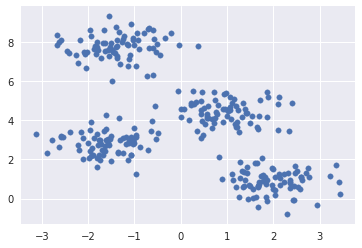

In [30]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=30);

легко выделить четыре кластера. Алгоритм k-средних делает это автоматически, а в Scikit-Learn используется типичный API-интерфейс оценки:

In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

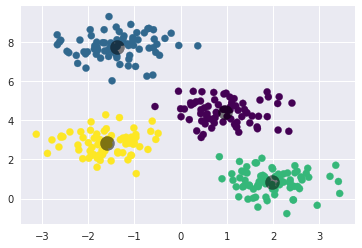

In [32]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Алгоритм k-means (по крайней мере, в этом простом случае) присваивает точки кластерам очень похоже на то, что мы видим. В конце концов, количество возможных комбинаций кластерных присвоений экспоненциально в количестве точек данных - исчерпывающий поиск будет очень и очень дорогостоящим. К счастью для нас, такой исчерпывающий поиск не нужен: вместо этого типичный подход к k-means включает в себя интуитивный итеративный подход, известный как **максимизация ожиданий**.

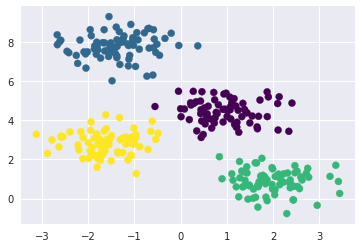

In [34]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Количество кластеров должно быть выбрано заранее

Другой общей проблемой с k-средствами является то, что вы должны сказать, сколько кластеров вы ожидаете: он не может узнать количество кластеров из данных. Например, если мы попросим алгоритм идентифицировать шесть кластеров, он с радостью продолжит поиск лучших шести кластеров:

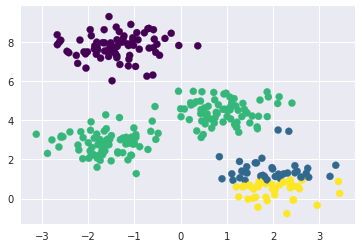

In [35]:

centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

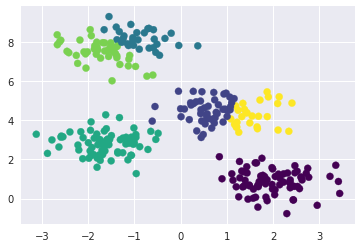

In [36]:

labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

k-means ограничен линейными границами кластера

Фундаментальные предположения о модели k-средних (точки будут ближе к их собственному центру кластера, чем к другим) означает, что алгоритм часто будет неэффективным, если кластеры имеют сложную геометрию.

В частности, границы между k-средними кластерами всегда будут **линейными**, а это означает, что он будет терпеть неудачу для более сложных границ. Рассмотрим следующие данные вместе с метками кластера, найденными типичным подходом k-средних:

In [37]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

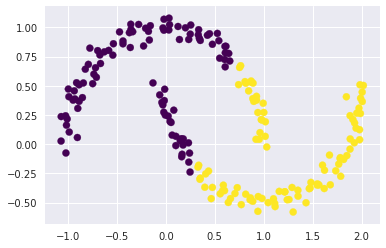

In [38]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');


## k-means on digits

In [39]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [40]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

В результате получается 10 кластеров в 64 разм. Обратите внимание, что сами кластерные центры являются 64-мерными точками и сами могут быть интерпретированы как «типичная» цифра внутри кластера. Посмотрим, как выглядят эти кластерные центры:

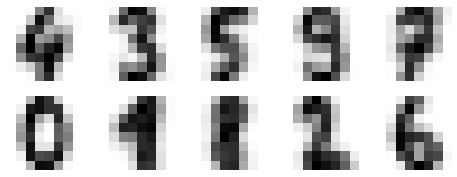

In [41]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Мы видим, что даже без меток KMeans может найти кластеры, центры которых являются узнаваемыми цифрами, возможно, за исключением 1 и 8.

Поскольку k-значки ничего не знают об идентичности кластера, метки 0-9 могут быть перегруппированы. Мы можем исправить это, сопоставляя каждую вычисленную метку кластера с истинными метками, найденными в них:

In [42]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

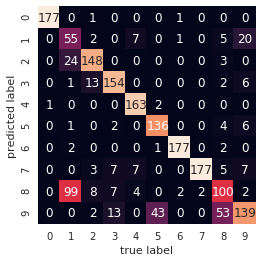

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [17]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9326655537006121

## Сжатие изображений
Одно интересное приложение кластеризации -- это цветовое сжатие изображений. Например, представьте, что у вас есть изображение с миллионами цветов. В большинстве изображений большое количество цветов не будет использоваться, и многие пиксели на изображении будут иметь одинаковые или даже одинаковые цвета.

Например, рассмотрите изображение, показанное на следующем рисунке, которое находится в модуле наборов данных Scikit-Learn.

/home/nestyme/anaconda3/lib/python3.5/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/home/nestyme/anaconda3/lib/python3.5/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


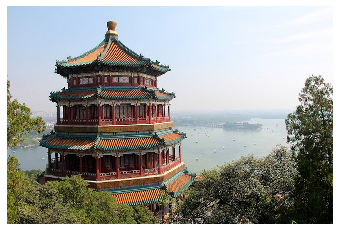

In [18]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

Само изображение хранится в трехмерном массиве размера (высота, ширина, RGB), содержащий красные / синие / зеленые вклады в виде целых чисел от 0 до 255:

In [19]:
china.shape

(427, 640, 3)

Один из способов, с помощью которого можно увидеть этот набор пикселей -- облако точек в трехмерном цветовом пространстве. Мы преобразуем данные в [n_samples x n_features] и пересканируем цвета так, чтобы они находились между 0 и 1:

In [20]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Мы можем визуализировать эти пиксели в этом цветовом пространстве, используя подмножество в 10 000 пикселей для эффективности:

In [21]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

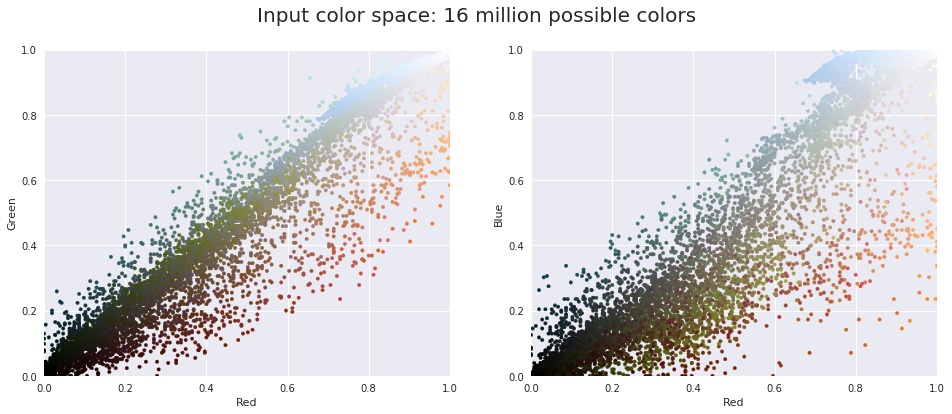

In [22]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Теперь давайте уменьшим эти 16 миллионов цветов до 16 цветов, используя кластеризацию k-пикселей в пространстве пикселей

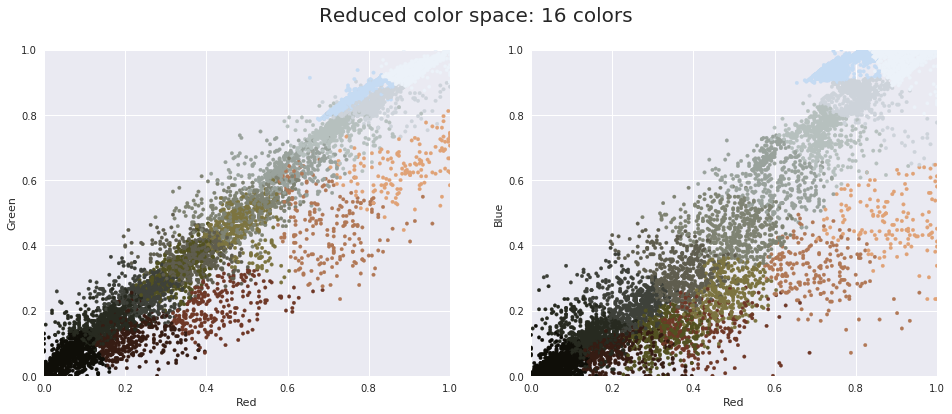

In [23]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

Результатом является перекрашивание исходных пикселей, где каждому пикселю присваивается цвет его ближайшего центра кластера

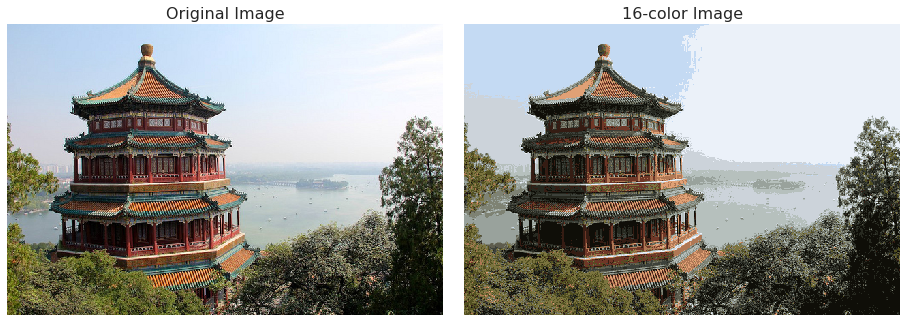

In [24]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);